In [1]:
import os
import h5py
import numpy as np
import matplotlib.pyplot as plt

In [4]:
def import_chosen_cells():
    
    source_folder = '/Users/ricardo/Documents/Temporary/Segmentations/Cells/'
    
    chosen_cells = {}
    
    for file_name in os.listdir(source_folder):
        
        stack = '_'.join(file_name.split('_')[:-1])
        
        if file_name.endswith('GOOD-CELLS.txt'):
            
            if not stack in chosen_cells:
                
                chosen_cells[stack] = set()
        
            with open(source_folder + file_name, 'r') as file:
                
                for cell in file:
                    
                    cell = (int(cell),)
                    
                    chosen_cells[stack].add(cell)
         
        if file_name.endswith('SPLIT-CELLS.txt'):
            
            if not stack in chosen_cells:
                
                chosen_cells[stack] = set()
            
            with open(source_folder + file_name, 'r') as file:
                
                for cells in file:
                    
                    cells = tuple([int(cell) for cell in cells.split()])
                    
                    chosen_cells[stack].add(cells)
                        
    return chosen_cells

In [5]:
chosen_cells = import_chosen_cells()

In [6]:
def find_cell_boundaries(image_stack):
    
    mask = np.ones_like(image_stack)
    
    # center-left:
    diff = (image_stack[:, 1:-1, 1:-1] - image_stack[:, 0:-2, 1:-1]) == 0
    
    mask[:, 1:-1, 1:-1] *= diff
    mask[:, 0:-2, 1:-1] *= diff
    
    # lower-left:
    diff = (image_stack[:, 1:-1, 1:-1] - image_stack[:, 0:-2, 0:-2]) == 0
    
    mask[:, 1:-1, 1:-1] *= diff
    mask[:, 0:-2, 0:-2] *= diff
    
    # lower-center:
    diff = (image_stack[:, 1:-1, 1:-1] - image_stack[:, 1:-1, 0:-2]) == 0
    
    mask[:, 1:-1, 1:-1] *= diff
    mask[:, 1:-1, 0:-2] *= diff
    
    # lower-right:
    diff = (image_stack[:, 1:-1, 1:-1] - image_stack[:, 2:, 0:-2]) == 0
    
    mask[:, 1:-1, 1:-1] *= diff
    mask[:, 2:, 0:-2] *= diff
    
    mask = np.logical_not(mask)
    
    boundaries = mask * image_stack
    
    return boundaries

In [7]:
def import_cell_data(chosen_cells):
    
    source_folder = '/Users/ricardo/Documents/Temporary/Segmentations/Segmentations/'
    
    file_names = os.listdir(source_folder)
    
    cell_data = {}
     
    for stack in chosen_cells:
        
        print(stack)
        
        for file_name in file_names:
            
            if file_name.startswith(stack) and file_name.endswith('.h5'):
                
                seg_file = h5py.File(source_folder + file_name, 'r')
                
                seg_data = seg_file['/segmentation'][()]
                
                seg_data = find_cell_edges(seg_data)
                
                if not stack in cell_data:
                    
                    cell_data[stack] = {}
                
                for cells in chosen_cells[stack]:
                    
                    print(cells)
                    
                    cell_data[stack][cells] = []
                    
                    coords = []
                    
                    for cell in cells:
                        
                        coords.append(np.argwhere(seg_data == cell))
                    
                    if len(coords) == 1:
                        
                        cell_data[stack][cells] = coords[0]
                    
                    elif len(coords) > 1:
                        
                        cell_data[stack][cells] = np.concatenate(coords)
            
                break
        
        break
    
    return cell_data

In [20]:
cell_data = import_cell_data(chosen_cells)

201106_NubG4-UASmyrGFP_COVERSLIP-FLAT_DISH-1-DISC-2_STACK
(330, 357)
(436, 407)
(571,)
(252,)
(279,)
(227,)
(804,)
(332,)
(460,)
(370,)
(437,)
(320,)
(821,)
(668,)
(322,)
(542,)
(490,)
(465,)
(620,)
(391,)
(647,)
(786,)
(491, 550)
(753, 710)
(291,)
(457,)
(767,)
(432,)
(462, 463)
(486,)
(690,)
(874, 892)
(887,)
(617,)
(592,)
(401,)
(376,)
(852,)


In [75]:
cell_data

{'201105_NubG4-UASmyrGFP_COVERSLIP-FLAT_DISH-1-DISC-2_STACK': {(955,
   951): array([[ 35, 557, 646],
         [ 36, 556, 646],
         [ 36, 557, 646],
         ...,
         [ 56, 597, 642],
         [ 56, 598, 643],
         [ 56, 600, 644]]),
  (1305,
   1299,
   1190): array([[101, 649, 909],
         [101, 649, 910],
         [101, 650, 910],
         ...,
         [109, 641, 911],
         [109, 641, 912],
         [109, 641, 913]]),
  (1045,): array([[ 17, 640, 700],
         [ 18, 637, 700],
         [ 18, 637, 701],
         ...,
         [146, 689, 789],
         [146, 690, 787],
         [146, 690, 788]]),
  (1186,): array([[ 14, 626, 801],
         [ 14, 626, 802],
         [ 14, 627, 800],
         ...,
         [151, 660, 927],
         [151, 660, 928],
         [151, 660, 929]]),
  (1469,): array([[  15, 1038, 1048],
         [  15, 1038, 1049],
         [  15, 1038, 1050],
         ...,
         [ 139, 1048, 1085],
         [ 139, 1049, 1084],
         [ 139, 1049, 10

In [9]:
def import_segmentation(file_name, cell_data):
    
    source_folder = '/Users/ricardo/Documents/Temporary/Segmentations/Segmentations/'
    
    seg_file = h5py.File(source_folder + file_name + '_predictions_gasp_average.h5', 'r')
    
    seg_stack = seg_file['/segmentation'][()]
    
    for cells in cell_data:
        
        if len(cells) > 1:
            
            for cell in cells[1:]:
                
                seg_stack[seg_stack == cell] = cells[0]
    
    basal_value, apical_value = 0, 0
    
    basal_values = np.unique(seg_stack[0])
        
    if basal_values.size == 1:
            
        basal_value = basal_values[0]
            
        print(basal_value)
        
        #seg_stack[seg_stack == basal_value] = 0
    
    apical_values = np.unique(seg_stack[-1])
        
    if apical_values.size == 1:
            
        apical_value = apical_values[0]
            
        print(apical_value)
        
        #seg_stack[seg_stack == apical_value] = 0
    
    return seg_stack, basal_value, apical_value

In [10]:
def find_cell_edges(stack):
    
    mask = np.ones_like(stack)
    
    # center-left:
    diff = (stack[:, 1:-1, 1:-1] - stack[:, 0:-2, 1:-1]) == 0
    
    mask[:, 1:-1, 1:-1] *= diff
    mask[:, 0:-2, 1:-1] *= diff
    '''
    # lower-left:
    diff = (stack[:, 1:-1, 1:-1] - stack[:, 0:-2, 0:-2]) == 0
    
    mask[:, 1:-1, 1:-1] *= diff
    mask[:, 0:-2, 0:-2] *= diff
    '''
    # lower-center:
    diff = (stack[:, 1:-1, 1:-1] - stack[:, 1:-1, 0:-2]) == 0
    
    mask[:, 1:-1, 1:-1] *= diff
    mask[:, 1:-1, 0:-2] *= diff
    '''
    # lower-right:
    diff = (stack[:, 1:-1, 1:-1] - stack[:, 2:, 0:-2]) == 0
    
    mask[:, 1:-1, 1:-1] *= diff
    mask[:, 2:, 0:-2] *= diff
    '''
    mask = np.logical_not(mask)
    
    edge_stack = mask * stack
    
    return edge_stack

In [11]:
def find_cell_vertices(stack):
    
    mask = np.zeros_like(stack)
    
    # center-left & lower-left:
    
    diff  = stack[:, 1:-1, 1:-1] != stack[:, 0:-2, 1:-1]
    diff &= stack[:, 0:-2, 1:-1] != stack[:, 0:-2, 0:-2]
    diff &= stack[:, 0:-2, 0:-2] != stack[:, 1:-1, 1:-1]
    
    mask[:, 1:-1, 1:-1] |= diff
    mask[:, 0:-2, 1:-1] |= diff
    mask[:, 0:-2, 0:-2] |= diff
    
    # lower-left & lower-center
    
    diff  = stack[:, 1:-1, 1:-1] != stack[:, 0:-2, 0:-2]
    diff &= stack[:, 0:-2, 0:-2] != stack[:, 1:-1, 0:-2]
    diff &= stack[:, 1:-1, 0:-2] != stack[:, 1:-1, 1:-1]
    
    mask[:, 1:-1, 1:-1] |= diff
    mask[:, 0:-2, 0:-2] |= diff
    mask[:, 1:-1, 0:-2] |= diff
    
    # lower-center & lower-right
    
    diff  = stack[:, 1:-1, 1:-1] != stack[:, 1:-1, 0:-2]
    diff &= stack[:, 1:-1, 0:-2] != stack[:, 2:  , 0:-2]
    diff &= stack[:, 2:  , 0:-2] != stack[:, 1:-1, 1:-1]
    
    mask[:, 1:-1, 1:-1] |= diff
    mask[:, 1:-1, 0:-2] |= diff
    mask[:, 2:  , 0:-2] |= diff
    
    vertex_stack = mask * stack
    
    return vertex_stack

In [12]:
def dilate_vertices(edge_stack, vertex_stack):
    
    mask = vertex_stack > 0
    
    dilated = mask.copy()
    
    dilated[:, 1:-1, 1:-1] |= mask[:, 0:-2, 1:-1]
    dilated[:, 1:-1, 1:-1] |= mask[:, 0:-2, 0:-2]
    dilated[:, 1:-1, 1:-1] |= mask[:, 1:-1, 0:-2]
    dilated[:, 1:-1, 1:-1] |= mask[:, 2:  , 0:-2]
    dilated[:, 1:-1, 1:-1] |= mask[:, 2:  , 1:-1]
    dilated[:, 1:-1, 1:-1] |= mask[:, 2:  , 2:  ]
    dilated[:, 1:-1, 1:-1] |= mask[:, 1:-1, 2:  ]
    dilated[:, 1:-1, 1:-1] |= mask[:, 0:-2, 2:  ]
    
    return dilated * edge_stack

In [21]:
example_stack_name = list(cell_data.keys())[0]

In [22]:
example_stack_name

'201106_NubG4-UASmyrGFP_COVERSLIP-FLAT_DISH-1-DISC-2_STACK'

In [13]:
import PIL.Image as img
import PIL.ImageSequence as ims

def import_image_stack(stack_name):
    
    source_folder = '/Users/ricardo/Documents/Temporary/Segmentations/Images/'
    
    image_stack = img.open(source_folder + stack_name + '.tif')
    
    image_arrays = []
    
    for image in ims.Iterator(image_stack):
        
        image_array = np.asarray(image)
        
        image_arrays.append(image_array)
    
    return np.array(image_arrays)

In [82]:
def find_stack_features(stack_name, cell_data):
    
    image_stack = import_image_stack(stack_name)
    
    seg_stack, basal, apical = import_segmentation(stack_name, cell_data[stack_name])
    
    edge_stack = find_cell_edges(seg_stack)
    
    lateral_stack = find_surface(seg_stack, excluded = (apical, basal))
    
    vertex_stack = find_cell_vertices(seg_stack)
    
    #vertex_stack = dilate_vertices(edge_stack, vertex_stack)
    
    return image_stack, seg_stack, edge_stack, lateral_stack, vertex_stack

In [83]:
image_stack, seg_stack, edge_stack, lateral_stack, vertex_stack = find_stack_features(example_stack_name, cell_data)

1
2


In [15]:
def find_surface(stack, excluded = (0,)):
    
    mask = np.zeros_like(stack)
    
    def exclude(array):
        
        nequals = (array != excluded[0])
        
        if len(excluded) > 1:
            
            for value in excluded[1:]:
                
                nequals &= (array != value)

        return nequals
    
    cell = exclude(stack[:, 1:-1, 1:-1])
    
    # center-left:
    diff  = (stack[:, 1:-1, 1:-1] - stack[:, 0:-2, 1:-1]) != 0
    diff &= exclude(stack[:, 0:-2, 1:-1]) & cell
    
    mask[:, 1:-1, 1:-1] |= diff
    mask[:, 0:-2, 1:-1] |= diff
    '''
    # lower-left:
    diff  = (stack[:, 1:-1, 1:-1] - stack[:, 0:-2, 0:-2]) != 0
    diff &= (stack[:, 0:-2, 0:-2] != surface) & cell
    
    mask[:, 1:-1, 1:-1] |= diff
    mask[:, 0:-2, 0:-2] |= diff
    '''
    # lower-center:
    diff  = (stack[:, 1:-1, 1:-1] - stack[:, 1:-1, 0:-2]) != 0
    diff &= exclude(stack[:, 1:-1, 0:-2]) & cell
    
    mask[:, 1:-1, 1:-1] |= diff
    mask[:, 1:-1, 0:-2] |= diff
    '''
    # lower-right:
    diff  = (stack[:, 1:-1, 1:-1] - stack[:, 2:, 0:-2]) != 0
    diff &= (stack[:, 2:, 0:-2] != surface) & cell
    
    mask[:, 1:-1, 1:-1] |= diff
    mask[:, 2:  , 0:-2] |= diff
    '''
    lateral_stack = mask * stack
    
    return lateral_stack

In [24]:
lateral_stack = find_surface(seg_stack, excluded = (1,6))

KeyboardInterrupt: 

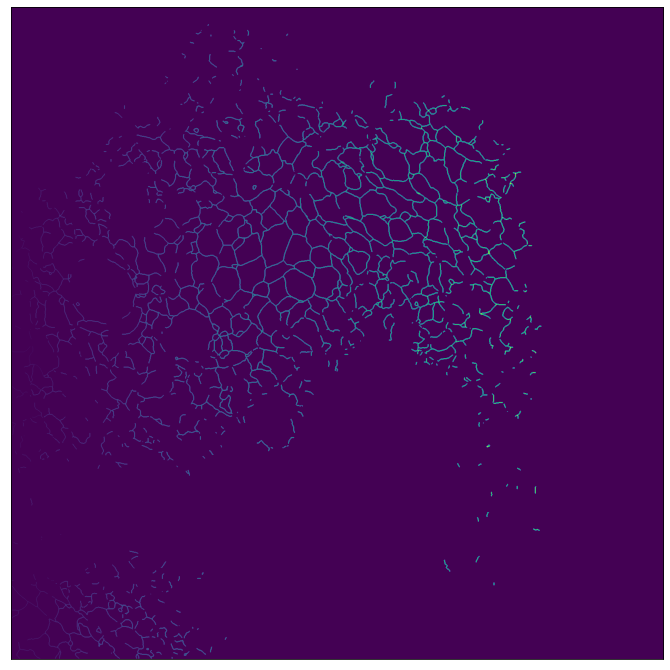

In [233]:
display_image_array(lateral_stack[138])

In [16]:
def find_lateral_surfaces(stack):
    
    mask = np.zeros_like(stack)
    
    cell = (stack[:, 1:-1, 1:-1] != 1)
    
    # center-left:
    diff  = (stack[:, 1:-1, 1:-1] - stack[:, 0:-2, 1:-1]) != 0
    diff &= (stack[:, 0:-2, 1:-1] != 1) & cell
    
    mask[:, 1:-1, 1:-1] |= diff
    mask[:, 0:-2, 1:-1] |= diff
    '''
    # lower-left:
    diff  = (stack[:, 1:-1, 1:-1] - stack[:, 0:-2, 0:-2]) != 0
    diff &= (stack[:, 0:-2, 0:-2] != 1) & cell
    
    mask[:, 1:-1, 1:-1] |= diff
    mask[:, 0:-2, 0:-2] |= diff
    '''
    # lower-center:
    diff  = (stack[:, 1:-1, 1:-1] - stack[:, 1:-1, 0:-2]) != 0
    diff &= (stack[:, 1:-1, 0:-2] != 1) & cell
    
    mask[:, 1:-1, 1:-1] |= diff
    mask[:, 1:-1, 0:-2] |= diff
    '''
    # lower-right:
    diff  = (stack[:, 1:-1, 1:-1] - stack[:, 2:, 0:-2]) != 0
    diff &= (stack[:, 2:, 0:-2] != 1) & cell
    
    mask[:, 1:-1, 1:-1] |= diff
    mask[:, 2:  , 0:-2] |= diff
    '''
    lateral_stack = mask * stack
    
    return lateral_stack

In [17]:
def find_open_surfaces(stack):
    
    mask = np.zeros_like(stack)
    
    empty_0 = (stack[:, 1:-1, 1:-1] == 1)
    
    # center-left:
    diff  = (stack[:, 1:-1, 1:-1] - stack[:, 0:-2, 1:-1]) != 0
    
    empty_1 = (stack[:, 0:-2, 1:-1] == 1)
    
    mask[:, 1:-1, 1:-1] |= diff & empty_1 & np.logical_not(empty_0)
    mask[:, 0:-2, 1:-1] |= diff & empty_0 & np.logical_not(empty_1)
    '''
    # lower-left:
    diff  = (stack[:, 1:-1, 1:-1] - stack[:, 0:-2, 0:-2]) != 0
    
    empty_1 =  (stack[:, 0:-2, 0:-2] == 1)
    
    mask[:, 1:-1, 1:-1] |= diff & empty_1 & np.logical_not(empty_0)
    mask[:, 0:-2, 0:-2] |= diff & empty_0 & np.logical_not(empty_1)
    '''
    # lower-center:
    diff  = (stack[:, 1:-1, 1:-1] - stack[:, 1:-1, 0:-2]) != 0
    
    empty_1 = (stack[:, 0:-2, 1:-1] == 1)
    
    mask[:, 1:-1, 1:-1] |= diff & empty_1 & np.logical_not(empty_0)
    mask[:, 1:-1, 0:-2] |= diff & empty_0 & np.logical_not(empty_1)
    '''
    # lower-right:
    diff  = (stack[:, 1:-1, 1:-1] - stack[:, 2:, 0:-2]) != 0
    
    empty_1 = (stack[:, 2:, 0:-2] == 1)
    
    mask[:, 1:-1, 1:-1] |= diff & empty_1 & np.logical_not(empty_0)
    mask[:, 2:  , 0:-2] |= diff & empty_0 & np.logical_not(empty_1)
    '''
    open_stack = mask * stack
    
    return open_stack

In [18]:
def find_open_surface(stack, adjacent):
    
    mask = np.zeros_like(stack)
    
    empty_0 = (stack[:, 1:-1, 1:-1] == adjacent)
    
    # center-left:
    diff  = (stack[:, 1:-1, 1:-1] - stack[:, 0:-2, 1:-1]) != 0
    
    empty_1 = (stack[:, 0:-2, 1:-1] == adjacent)
    
    mask[:, 1:-1, 1:-1] |= diff & empty_1 & np.logical_not(empty_0)
    mask[:, 0:-2, 1:-1] |= diff & empty_0 & np.logical_not(empty_1)
    '''
    # lower-left:
    diff  = (stack[:, 1:-1, 1:-1] - stack[:, 0:-2, 0:-2]) != 0
    
    empty_1 =  (stack[:, 0:-2, 0:-2] == adjacent)
    
    mask[:, 1:-1, 1:-1] |= diff & empty_1 & np.logical_not(empty_0)
    mask[:, 0:-2, 0:-2] |= diff & empty_0 & np.logical_not(empty_1)
    '''
    # lower-center:
    diff  = (stack[:, 1:-1, 1:-1] - stack[:, 1:-1, 0:-2]) != 0
    
    empty_1 = (stack[:, 0:-2, 1:-1] == adjacent)
    
    mask[:, 1:-1, 1:-1] |= diff & empty_1 & np.logical_not(empty_0)
    mask[:, 1:-1, 0:-2] |= diff & empty_0 & np.logical_not(empty_1)
    '''
    # lower-right:
    diff  = (stack[:, 1:-1, 1:-1] - stack[:, 2:, 0:-2]) != 0
    
    empty_1 = (stack[:, 2:, 0:-2] == adjacent)
    
    mask[:, 1:-1, 1:-1] |= diff & empty_1 & np.logical_not(empty_0)
    mask[:, 2:  , 0:-2] |= diff & empty_0 & np.logical_not(empty_1)
    '''
    open_stack = mask * stack
    
    return open_stack

In [36]:
apical_stack = find_open_surface(seg_stack, 2)

In [26]:
basal_stack = find_open_surface(seg_stack, 1)

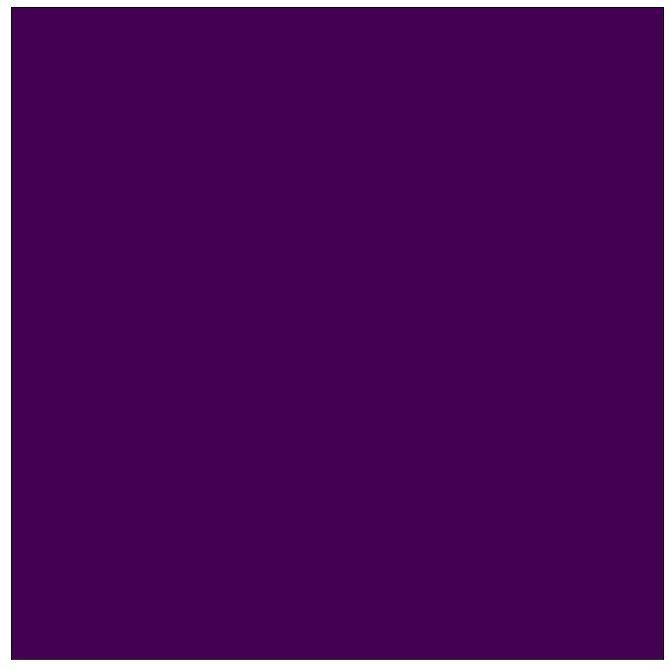

In [34]:
display_image_array(apical_stack[15])

In [19]:
def organise_cell_data(cell_data, stack_name):
    
    for cell in cell_data[stack_name]:
        
        coords = cell_data[stack_name][cell]
        
        sliced_coords = {}
        
        for z in np.unique(coords[:, 0]):
            
            sliced_coords[z] = coords[coords[:, 0] == z, 1:]
        
        return sliced_coords

In [54]:
example_coords = organise_cell_data(cell_data, example_stack_name)

In [41]:
example_coords

{23: array([[1245,  556],
        [1245,  557],
        [1245,  558],
        [1245,  559],
        [1246,  554],
        [1246,  555],
        [1246,  560],
        [1247,  554],
        [1247,  560],
        [1248,  553],
        [1248,  560],
        [1249,  553],
        [1249,  560],
        [1250,  552],
        [1250,  560],
        [1251,  552],
        [1251,  560],
        [1252,  552],
        [1252,  559],
        [1253,  552],
        [1253,  559],
        [1254,  552],
        [1254,  559],
        [1255,  553],
        [1255,  554],
        [1255,  559],
        [1256,  555],
        [1256,  559],
        [1257,  556],
        [1257,  557],
        [1257,  558]]),
 24: array([[1236,  554],
        [1236,  555],
        [1236,  556],
        [1236,  557],
        [1236,  558],
        [1236,  559],
        [1236,  560],
        [1236,  561],
        [1236,  562],
        [1236,  563],
        [1236,  564],
        [1236,  565],
        [1237,  551],
        [1237,  552],


In [52]:
def display_coords(coords):

    min_x, min_y = coords.min(axis = 0)
    max_x, max_y = coords.max(axis = 0)
    
    coords[:, 0] -= min_x - 1
    coords[:, 1] -= min_y - 1
    
    image = np.zeros((max_x - min_x + 3, max_y - min_y + 3))
    
    image[tuple(coords.transpose())] = 1
    
    display_image_array(image)

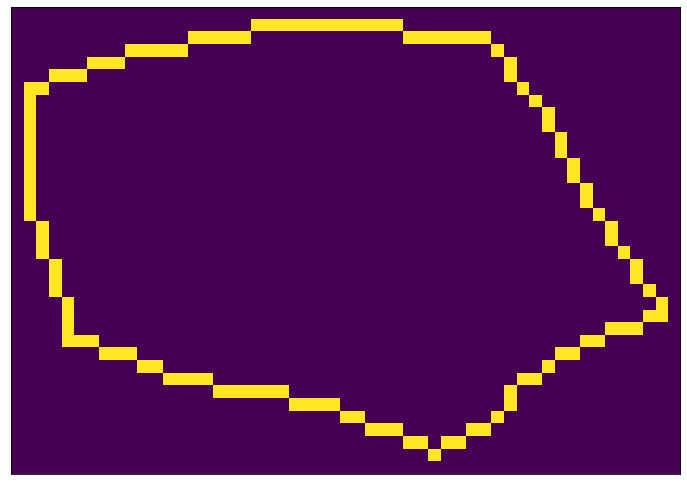

In [53]:
display_coords(example_coords[50])

In [77]:
def organise_cell_data(cell_data, stack_name, vertex_stack):
    
    for cell in cell_data[stack_name]:
        
        image_stack, edge_stack, vertex_stack
        
        coords = cell_data[stack_name][cell]
        
        sliced_coords = {}
        vertex_coords = {}
        
        for z in np.unique(coords[:, 0]):
            
            sliced_coords[z] = coords[coords[:, 0] == z, 1:]
            
            vertex_coords[z] = vertex_stack[z][tuple(sliced_coords[z].transpose())]
            #print(vertex_coords[z].shape)
            vertex_coords[z] = sliced_coords[z][vertex_coords[z] > 0]
        
        return sliced_coords, vertex_coords

In [84]:
example_coords = organise_cell_data(cell_data, example_stack_name, vertex_stack)

In [79]:
example_coords[1]

{23: array([], shape=(0, 2), dtype=int64),
 24: array([], shape=(0, 2), dtype=int64),
 25: array([], shape=(0, 2), dtype=int64),
 26: array([], shape=(0, 2), dtype=int64),
 27: array([[1254,  520],
        [1255,  521],
        [1256,  522],
        [1258,  526],
        [1258,  527],
        [1258,  528],
        [1259,  529]]),
 28: array([[1223,  526],
        [1223,  527],
        [1223,  528],
        [1224,  525],
        [1229,  565],
        [1229,  566],
        [1229,  567],
        [1230,  568],
        [1230,  569],
        [1231,  513],
        [1231,  514],
        [1231,  570],
        [1232,  512],
        [1232,  571],
        [1233,  572],
        [1234,  509],
        [1234,  572],
        [1235,  508],
        [1236,  508],
        [1237,  507],
        [1238,  506],
        [1251,  512],
        [1252,  513],
        [1252,  514],
        [1260,  532],
        [1261,  533],
        [1261,  534],
        [1261,  535],
        [1269,  549],
        [1270,  550],
    

In [128]:
def display_RGB_array(image_array_1, image_array_2):
    
    image_array_1 = (image_array_1 > 0).astype(float)
    image_array_2 = (image_array_2 > 0).astype(float)
    image_array_3 = np.zeros_like(image_array_1)
    
    image_array = np.dstack((image_array_1, image_array_2, image_array_3))
    
    print(image_array.shape)
    
    fig = plt.figure(figsize = (12.0, 12.0))

    plt.imshow(image_array)#, cmap = cmap)

    plt.xticks([])
    plt.yticks([])

    plt.show()

In [171]:
def display_coord_features(edge_coords, vertex_coords, extra_coords = None):
    
    min_x, min_y = edge_coords.min(axis = 0)
    max_x, max_y = edge_coords.max(axis = 0)
    
    edge_coords[:, 0] -= min_x - 1
    edge_coords[:, 1] -= min_y - 1
    
    vertex_coords[:, 0] -= min_x - 1
    vertex_coords[:, 1] -= min_y - 1
    
    image_array_1 = np.zeros((max_x - min_x + 3, max_y - min_y + 3))
    image_array_2 = np.zeros((max_x - min_x + 3, max_y - min_y + 3))
    image_array_3 = np.zeros((max_x - min_x + 3, max_y - min_y + 3))
    
    image_array_1[tuple(edge_coords.transpose())] = 1
    image_array_2[tuple(vertex_coords.transpose())] = 1
    
    if extra_coords is not None:
        
        image_array_3[tuple(extra_coords.transpose())] = 1
    
    image_array = np.dstack((image_array_1, image_array_2, image_array_3))
    
    print(image_array.shape)
    
    fig = plt.figure(figsize = (12.0, 12.0))

    plt.imshow(image_array)#, cmap = cmap)

    plt.xticks([])
    plt.yticks([])

    plt.show()

(37, 53, 3)


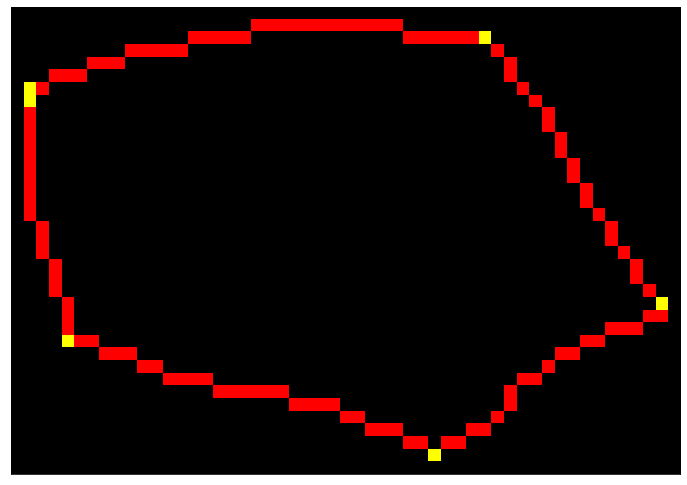

In [170]:
display_coord_features(*map(lambda x: x[50], example_coords))

In [295]:
def find_coord_order(coords):
    print(coords.shape)
    print(coords[np.newaxis].shape)
    print(coords[:,np.newaxis].shape)
    within = np.abs(coords[:,np.newaxis,:] - coords[np.newaxis,:,:]) <= 1
    print(within.shape)
    #within = np.triu(within.all(axis = 2), 1)
    within = within.all(axis = 2)
    within[np.diag_indices_from(within)] = 0
    print(within.shape)
    
    return within, within.sum(axis = 0)

In [296]:
neighbours, neighbour_numbers = find_coord_order(example_coords[0][50])
print(neighbour_numbers)

(126, 2)
(1, 126, 2)
(126, 1, 2)
(126, 126, 2)
(126, 126)
[2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 3 2 3 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 3 2 3 2 3 2 2 2 2 3 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2]


In [297]:
def display_neighbour(coords, neighbours, neighbour_numbers):
    
    chosen_coord = np.argwhere(neighbour_numbers == 3)[0]
    chosen_coord_mask = np.zeros_like(neighbour_numbers).astype(bool)
    chosen_coord_mask[chosen_coord] = True
    
    neighbour_coords = coords[neighbours[:,chosen_coord[0]] == 1]
    chosen_coord = coords[chosen_coord_mask]
    
    display_coord_features(coords, chosen_coord, neighbour_coords)

(37, 53, 3)


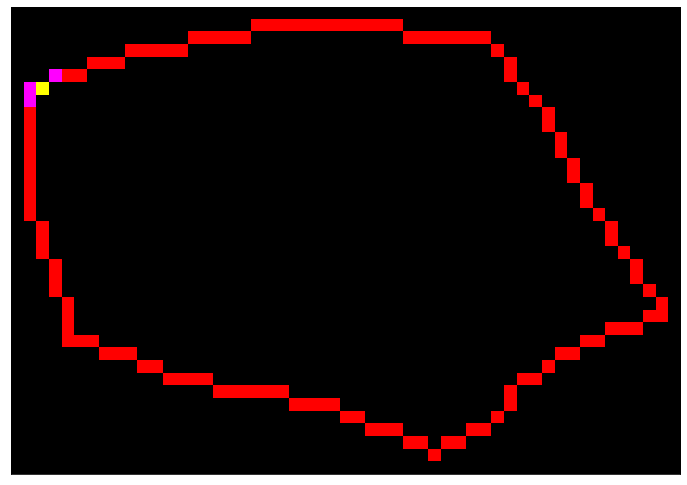

In [298]:
display_neighbour(example_coords[0][50], neighbours, neighbour_numbers)

(37, 53, 3)


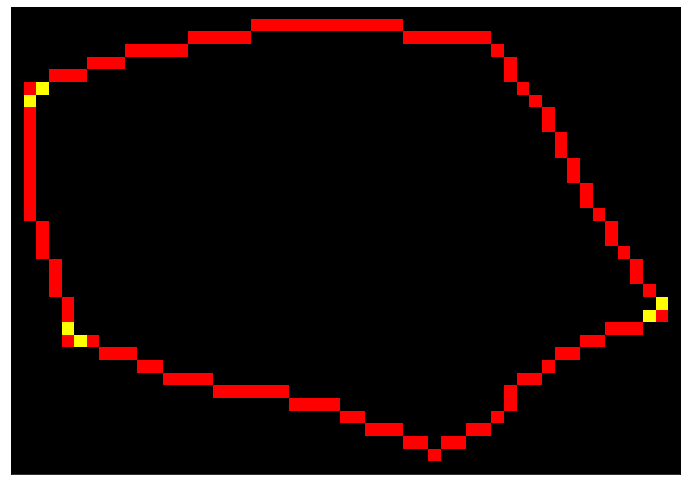

In [287]:
display_coord_features(example_coords[0][50], example_coords[0][50][neighbour_numbers == 3])

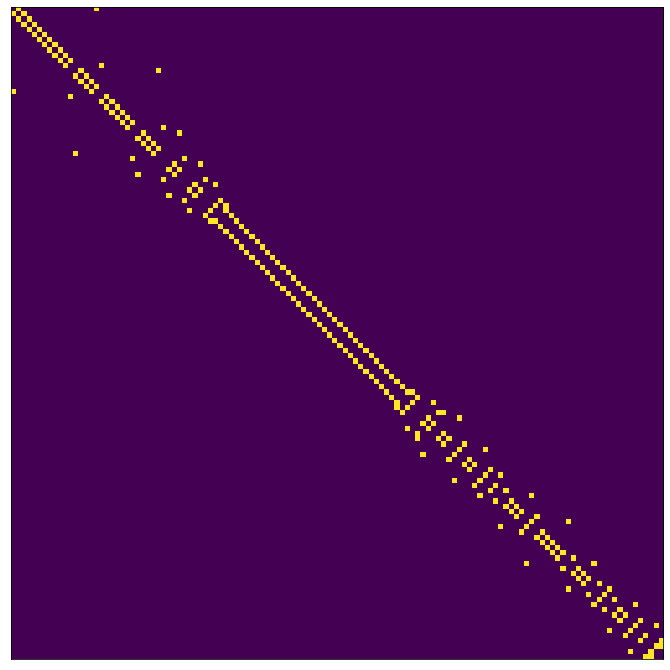

In [288]:
display_image_array(neighbours.astype(int))

In [342]:
def find_coord_order_contd(neighbour_matrix):
    '''
    f0 = np.argmax(neighbour_matrix, axis = 0)
    l0 = np.argmax(np.flip(neighbour_matrix, axis = 1), axis = 0)
    
    f1 = np.argmax(neighbour_matrix, axis = 1)
    l1 = np.argmax(np.flip(neighbour_matrix, axis = 0), axis = 1)
    '''
    neighbours = neighbour_matrix.copy()
    
    f = np.argmax(neighbours, axis = 0)
    
    #neighbours[f] = 0
    
    l = f[1:].size - np.argmax(np.flip(neighbours, axis = 0), axis = 0)
    
    print(f, l)
    
    
    
    '''
    index = 0
    
    values = [index]
    
    value = f[index]
    
    values.append(value)
    
    index = l[index]
    
    values.append(index)
    
    value = f[index]
    
    values.append(value)
    
    index = l[index]
    
    values.append(index)
    '''
    '''
    c = []
    
    c.append(f0[0])
    c.append(l0[0])
    
    i = l0[0] + 1
    
    while True:
        print(f1[i], l1[i])
        if f1[i] == i:

            i = l1[i]
            if i in c: break
            c.append(i)

        elif l1[i] == i:

            i = f1[i]
            if i in c: break
            c.append(i)
        
        else:
            
            print('bad')
            break

        if f0[i] == i:

            i = l0[i]
            if i in c: break
            c.append(i)

        elif l0[i] == i:

            i = f0[l0[0]]
            if i in c: break
            c.append(i)
            
        else:
            
            print('also bad')
            break
    
    return c
    '''

In [343]:
find_coord_order_contd(neighbours)

[  1   0   1   2   3   4   5   6   7   8   9  10  13  12  13  14   0  11
  17  18  19  20  21  22  25  24  25  26  12  23  31  30  24  29  35  34
  30  33  39  34  37  38  40  41  42  43  44  45  46  47  48  49  50  51
  52  53  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69
  70  71  72  73  74  74  75  80  79  76  78  78  83  86  79  84  87  88
  91  85  89  92  90  93  95  96  97 100  94  98 101 102 103 104 105  99
 106 108 109 110 107 111 113 112 114 116 117 120 115 118 121 124 119 122] [ 16   2   3   4   5   6   7   8   9  10  11  17  28  14  15  16  15  18
  19  20  21  22  23  29  32  26  27  28  27  33  36  32  31  37  39  36
  35  40  41  41  42  43  44  45  46  47  48  49  50  51  52  53  54  55
  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72  73
  74  75  77  78  81  76  83  86  81  80  83  84  87  91  85  88  89  92
  94  90  93  95 100  96  97  98 101 107  99 102 103 104 105 106 108 112
 109 110 111 113 115 114 116 120 117 118 121 124 1

In [292]:
def display_image_array(image_array):
    
    fig = plt.figure(figsize = (12.0, 12.0))
    
    plt.imshow(image_array)#, cmap = cmap)
    
    plt.xticks([])
    plt.yticks([])
    
    plt.show()

In [28]:
%gui qt5
import napari

from vispy.color.colormap import Colormap as colormap

from qtpy.QtCore import Qt
from qtpy.QtWidgets import QListView

from qtpy.QtGui import QStandardItem
from qtpy.QtGui import QStandardItemModel

In [344]:
viewer = napari.Viewer()
viewer.theme = 'light'

items = QListView()
model = QStandardItemModel()
items.setModel(model)

viewer.window.add_dock_widget(items, name = 'items', area = 'left')

cmin = seg_stack.min()
cmax = seg_stack.max()
cnum = cmax - cmin

cmap_controls = np.array((0.0, 0.05, 0.95, 1.0))

cmap_colors = np.zeros((3, 3))
cmap_colors[1,0] = 1.0
cmap = colormap(colors = cmap_colors, controls = cmap_controls, interpolation = 'zero')

cmap_colors = np.zeros((3, 3))
cmap_colors[(0,2),(0,0)] = 1.0
cinv = colormap(colors = cmap_colors, controls = cmap_controls, interpolation = 'zero')

cmap_colors = np.zeros((3, 3))
cmap_colors[(0,2,0,2),(0,0,1,1)] = 1.0
cyel = colormap(colors = cmap_colors, controls = cmap_controls, interpolation = 'zero')

cmap_colors = np.zeros((3, 3))
cmap_colors[(0,2,0,2),(0,0,2,2)] = 1.0
cmag = colormap(colors = cmap_colors, controls = cmap_controls, interpolation = 'zero')

cmap_colors = np.zeros((3, 3))
cmap_colors[(0,2),(2,2)] = 1.0
csom = colormap(colors = cmap_colors, controls = cmap_controls, interpolation = 'zero')


#contrast = [749.0, 751.0]
#contrast = [cmin - cnum * 0.1, cmax + cnum * 0.1]
#contrast = [cmin, cmax]
contrast = [-0.5, 0.5]

segmentation = viewer.add_image(seg_stack, colormap = 'Greys',
                                blending = 'opaque', 
                                visible = True)

image = viewer.add_image(image_stack, blending = 'opaque',
                                visible = True)
'''
boundaries = viewer.add_image(edge_stack, colormap = cinv, 
                                contrast_limits = contrast,
                                blending = 'additive', 
                                visible = False, metadata = {})
'''
lateral = viewer.add_image(lateral_stack, colormap = cyel, 
                                contrast_limits = contrast,
                                blending = 'additive', 
                                visible = True, metadata = {})
apical = viewer.add_image(apical_stack, colormap = csom, 
                                contrast_limits = contrast,
                                blending = 'additive', 
                                visible = True, metadata = {})
basal = viewer.add_image(basal_stack, colormap = cinv, 
                                contrast_limits = contrast,
                                blending = 'additive', 
                                visible = True, metadata = {})

image.selected = False
#boundaries.selected = False
segmentation.selected = True

apical.selected = False
lateral.selected = False
basal.selected = False

#viewer.window.qt_viewer.dockLayerList.setVisible(False)
#viewer.window.qt_viewer.dockLayerControls.setVisible(False)

#boundaries.metadata['index'] = 0
#boundaries.metadata['cells'] = list(cell_data[example_stack_name].keys())

#item_string = 'Cell: ' + str(boundaries.metadata['cells'][0])
#item = QStandardItem(item_string)
#model.appendRow(item)

#boundaries.metadata['item'] = item

#cell = boundaries.metadata['cells'][0]
#boundaries.contrast_limits = [value - 0.5, value + 0.5]
#apical.contrast_limits = [value - 0.5, value + 0.5]
#lateral.contrast_limits = [value - 0.5, value + 0.5]
#basal.contrast_limits = [value - 0.5, value + 0.5]


@viewer.bind_key('Space')
def select_boundary(viewer):
    
    if segmentation.visible:
        
        index = boundaries.metadata['index']
        cell = boundaries.metadata['cells'][index]
        
        boundaries.colormap = cmap
        
        boundaries.contrast_limits = [cell - 0.5, cell + 0.5]
        apical.contrast_limits = [cell - 0.5, cell + 0.5]
        lateral.contrast_limits = [cell - 0.5, cell + 0.5]
        basal.contrast_limits = [cell - 0.5, cell + 0.5]
        
        segmentation.visible = False
    
    else:
        
        boundaries.colormap = cinv
        
        boundaries.contrast_limits = [-0.5, 0.5]
        apical.contrast_limits = [-0.5, 0.5]
        lateral.contrast_limits = [-0.5, 0.5]
        basal.contrast_limits = [-0.5, 0.5]
        segmentation.visible = True

@viewer.bind_key('b')
def toggle_boundaries(viewer):
    
    boundaries.visible = not boundaries.visible

@viewer.bind_key('v')
def cycle_cells(viewer):
    
    if not segmentation.visible:
        
        boundaries.metadata['index'] += 1
        
        index = boundaries.metadata['index']
        
        cell = boundaries.metadata['cells'][index]
        
        item = boundaries.metadata['item']
        
        item_string = 'Cell: ' + str(cell)
        
        item.setText(item_string)
        
        boundaries.contrast_limits = [cell - 0.5, cell + 0.5]
        apical.contrast_limits = [cell - 0.5, cell + 0.5]
        lateral.contrast_limits = [cell - 0.5, cell + 0.5]
        basal.contrast_limits = [cell - 0.5, cell + 0.5]
        
@viewer.bind_key('Backspace')
def close(viewer):
    
    viewer.close()